## Context

### Following are the factors that can impact a credit card approval for a customer

- His CIBIL/Credit history, how he has been paying his debts/borrows in past
- Income of customer, Lenders usually have a minimum amount earned each year for  customer 
- Criminal history
- Financial history
- Credit scores from various orgs

In [140]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# To get diferent metric scores
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
#     plot_confusion_matrix,
    precision_recall_curve,
    roc_curve,
    make_scorer
)
import matplotlib.pyplot as plt
import os
import seaborn as sns


### Reading data files

In [48]:
CreditRecord = pd.read_csv(r'C:\Users\pprab\Desktop\credit_card_prediction\data\credit_record.csv')
appRecord = pd.read_csv(r'C:\Users\pprab\Desktop\credit_card_prediction\data\application_record.csv')

### Data Dictionary

- Status column : 
    - 0: 1-29 days past due 
    - 1: 30-59 days past due 
    - 2: 60-89 days overdue 
    - 3: 90-119 days overdue 
    - 4: 120-149 days overdue 
    - 5: Overdue or bad debts, 

    - write-offs for more than 150 days 
    - C: paid off that month 
    - X: No loan for the month
                    


### Data exploration of applicatio record table

In [49]:
print(CreditRecord.shape, appRecord.shape)

(1048575, 3) (438557, 18)


In [50]:
CreditRecord.head(5)

ID  MONTHS_BALANCE STATUS
0  5001711               0      X
1  5001711              -1      0
2  5001711              -2      0
3  5001711              -3      0
4  5001712               0      C

In [51]:
CreditRecord['MONTHS_BALANCE'].value_counts()

-1     34436
-2     34209
 0     33856
-3     33854
-4     33365
       ...  
-56     2109
-57     1649
-58     1255
-59      820
-60      415
Name: MONTHS_BALANCE, Length: 61, dtype: int64

In [52]:
CreditRecord['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

### Comments

- There a quite many number of customers with 1 month due
- While many customers have paid the amount on time
- We do have significant customers with 3,4,5 months due for payments
     

### MIssing value check

- Comments
    - There are many customers whose occupation type in missing

In [69]:
appRecord.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

## Months balance vs Status

<AxesSubplot: xlabel='STATUS', ylabel='MONTHS_BALANCE'>

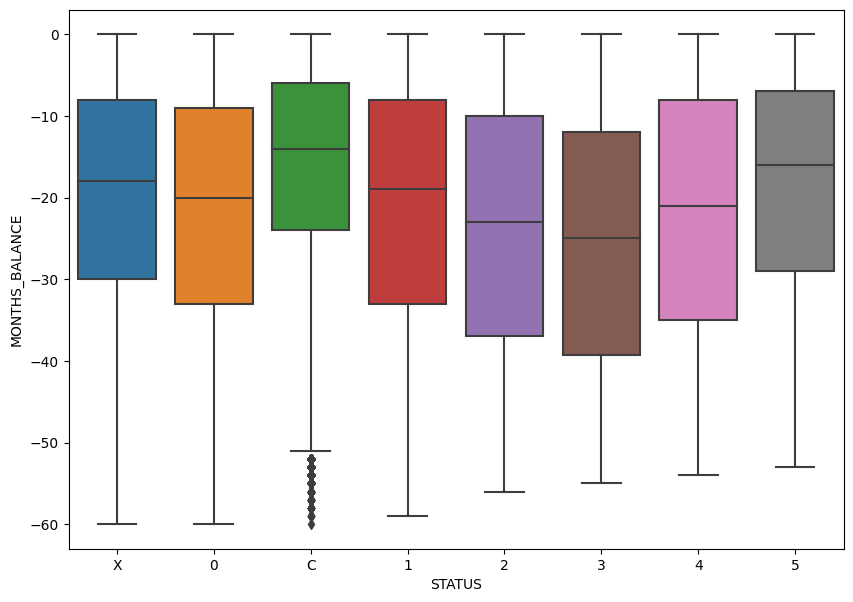

In [70]:
plt.figure(figsize=(10, 7))
sns.boxplot(x=CreditRecord['STATUS'], y=CreditRecord['MONTHS_BALANCE'])

### Data preprocessing

In [71]:
appRecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

### Label encoding the object columns

In [72]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

objectColumns = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]
for objColumn in objectColumns:
    label = LabelEncoder()
    appRecord[objColumn] = label.fit_transform(appRecord[objColumn].values)

In [73]:
Ocupation_dict = {'Security staff':0, 'Sales staff':1, 
                  'Accountants':2, 'Laborers':3, 
                  'Managers':4,'Drivers':5, 
                  'Core staff':6, 'High skill tech staff':7, 
                  'Cleaning staff':8,'Private service staff':9,
                  'Cooking staff':10, 'Low-skill Laborers':11,
                  'Medicine staff':12, 'Secretaries':13,
                  'Waiters/barmen staff':14, 'HR staff':15,
                  'Realty agents':16, "IT staff":17}

appRecord['OCCUPATION_TYPE'] = appRecord['OCCUPATION_TYPE'].map(Ocupation_dict)

In [74]:
appRecord.drop(['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True, axis=1)

In [75]:
map_status = {'C' : 1,
              'X' : 1,
              '0' : 1,
              '1' : 0,
              '2' : 0,
              '3' : 0,
              '4' : 0,
              '5' : 0}
CreditRecord["STATUS"] = CreditRecord['STATUS'].map(map_status)

In [76]:
df_credit = appRecord.merge(CreditRecord, how='inner', on=['ID'])
df_credit.head(6)

ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804            1             1                1             0   
1  5008804            1             1                1             0   
2  5008804            1             1                1             0   
3  5008804            1             1                1             0   
4  5008804            1             1                1             0   
5  5008804            1             1                1             0   

   AMT_INCOME_TOTAL  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0          427500.0                 4                    1   
1          427500.0                 4                    1   
2          427500.0                 4                    1   
3          427500.0                 4                    1   
4          427500.0                 4                    1   
5          427500.0                 4                    1   

   NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  FLAG_MOBIL  FLAG_WORK_PHONE  \
0                   0                  4           1                1   
1                   0                  4           1                1   
2                   0                  4           1                1   
3                   0                  4           1                1   
4                   0                  4           1                1   
5                   0                  4           1                1   

   FLAG_PHONE  FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  MONTHS_BALANCE  \
0           0           0              NaN              2.0               0   
1           0           0              NaN              2.0              -1   
2           0           0              NaN              2.0              -2   
3           0           0              NaN              2.0              -3   
4           0           0              NaN              2.0              -4   
5           0           0              NaN              2.0              -5   

   STATUS  
0       1  
1       1  
2       1  
3       1  
4       1  
5       1

In [77]:
objectColumns.append('OCCUPATION_TYPE')
objectColumns.append('STATUS')

In [78]:
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [141]:
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [79]:
appRecord.NAME_HOUSING_TYPE.value_counts()

1    393831
5     19077
2     14214
4      5974
3      3922
0      1539
Name: NAME_HOUSING_TYPE, dtype: int64

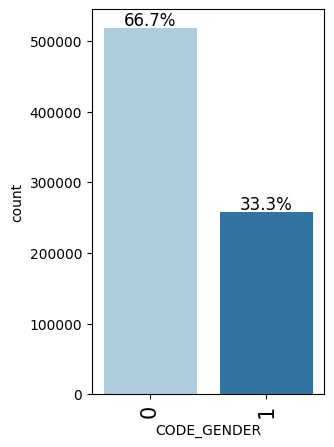

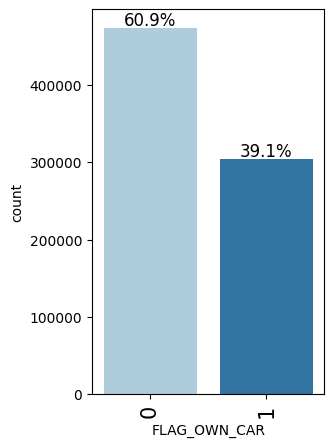

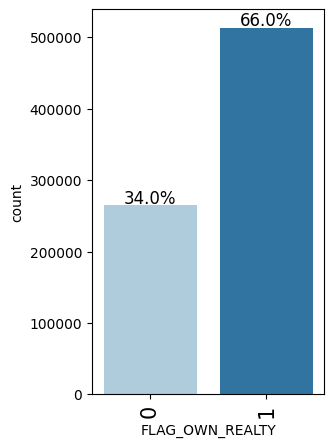

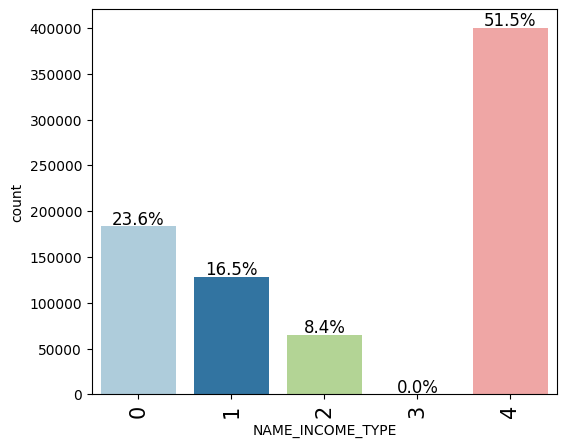

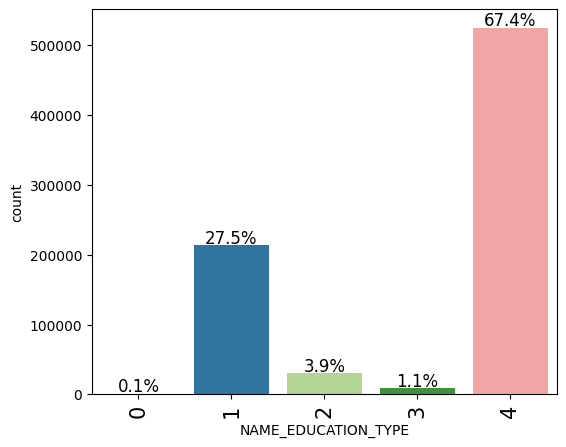

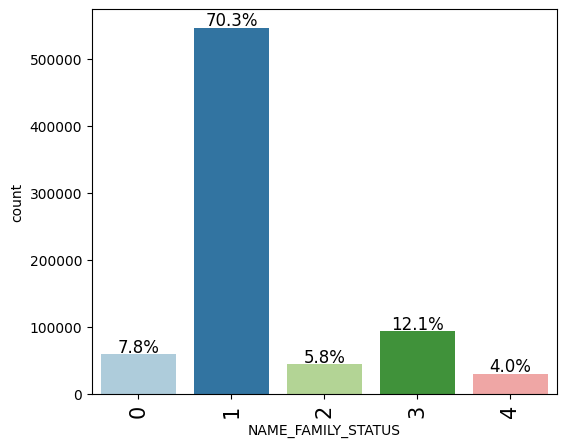

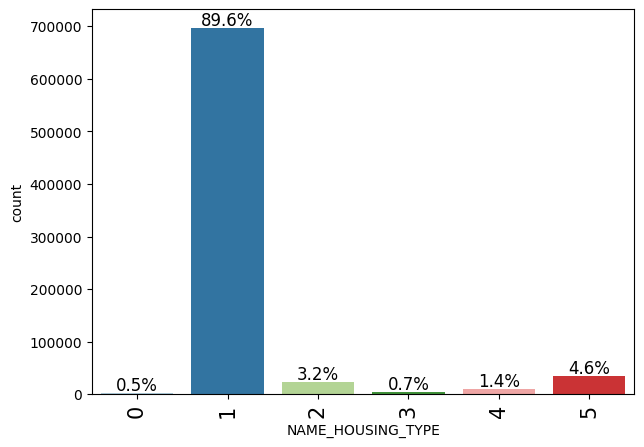

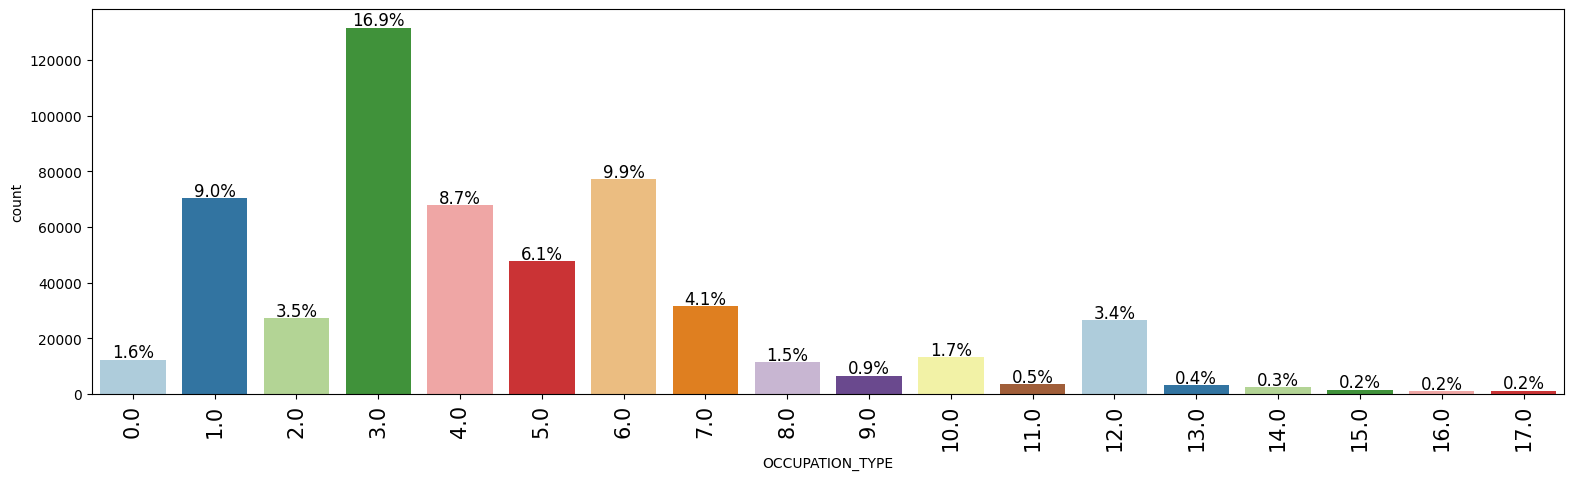

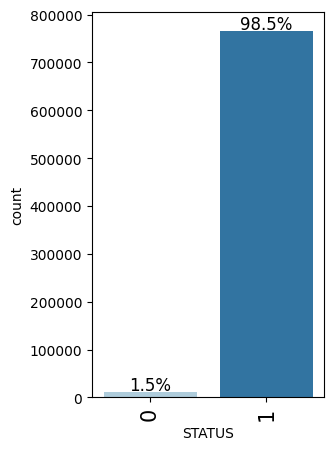

In [80]:
for obj_cols in objectColumns:
    labeled_barplot(df_credit, obj_cols, perc=True)

- 67% of customers are male
- 61% own a car
- 34% own realty
- 52% have job type as type 4
- 67% have education type as 4
- 70% have family satatus as 1 member
- 90% have housing type as 1(have their own house)
- 17% have occupation type as Managers
- 50% users are working
- 100% have mobiles
- 90% have email
- 99.4% is not approved for credit card

STATUS           0       1     All
CODE_GENDER                       
All          11575  766140  777715
0             7155  511696  518851
1             4420  254444  258864
------------------------------------------------------------------------------------------------------------------------


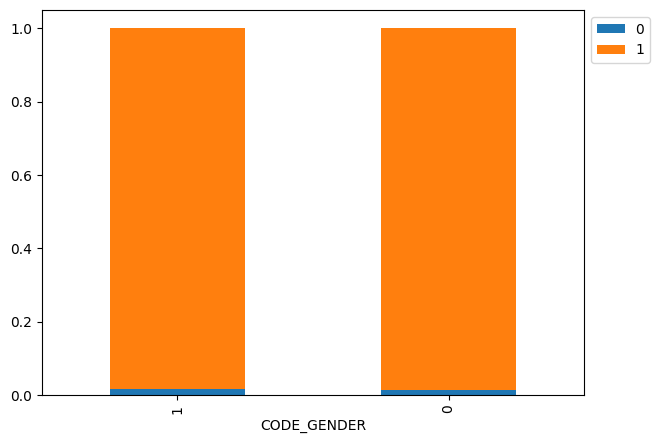

In [82]:
stacked_barplot(df_credit, "CODE_GENDER", "STATUS")

STATUS                 0       1     All
NAME_HOUSING_TYPE                       
All                11575  766140  777715
1                  10227  686924  697151
5                    566   35169   35735
2                    429   24211   24640
4                    172   10726   10898
3                    122    5514    5636
0                     59    3596    3655
------------------------------------------------------------------------------------------------------------------------


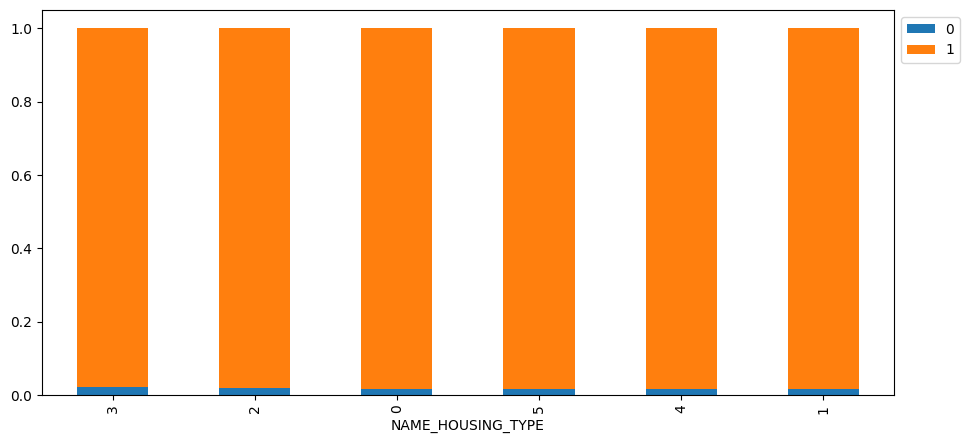

In [83]:
stacked_barplot(df_credit, "NAME_HOUSING_TYPE", "STATUS")

STATUS                  0       1     All
NAME_FAMILY_STATUS                       
All                 11575  766140  777715
1                    7863  538756  546619
3                    1724   92611   94335
0                     884   59458   60342
2                     664   44591   45255
4                     440   30724   31164
------------------------------------------------------------------------------------------------------------------------


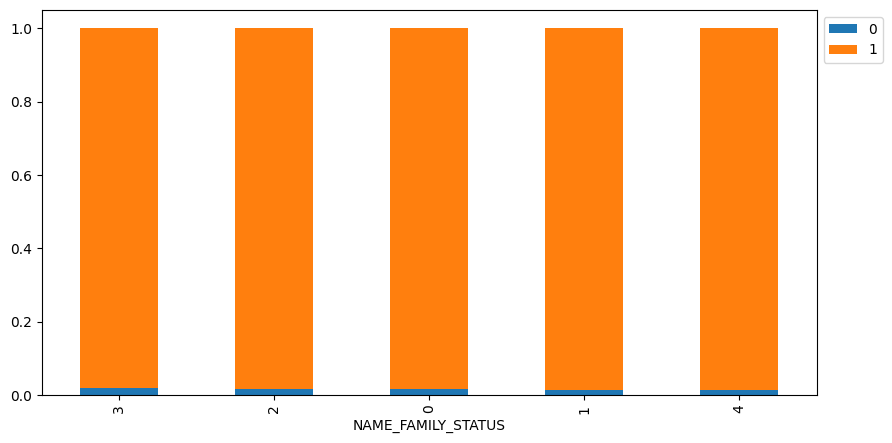

In [84]:
stacked_barplot(df_credit, "NAME_FAMILY_STATUS", "STATUS")

STATUS                   0       1     All
NAME_EDUCATION_TYPE                       
All                  11575  766140  777715
4                     7524  516737  524261
1                     3201  210432  213633
2                      663   29666   30329
3                      179    8476    8655
0                        8     829     837
------------------------------------------------------------------------------------------------------------------------


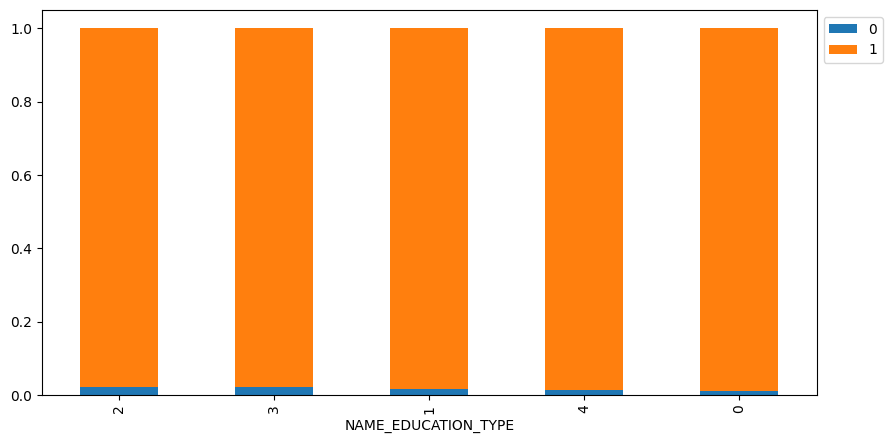

In [85]:
stacked_barplot(df_credit, "NAME_EDUCATION_TYPE", "STATUS")

STATUS                0       1     All
NAME_INCOME_TYPE                       
All               11575  766140  777715
4                  5650  394514  400164
0                  3265  180120  183385
1                  1767  126625  128392
2                   892   64545   65437
3                     1     336     337
------------------------------------------------------------------------------------------------------------------------


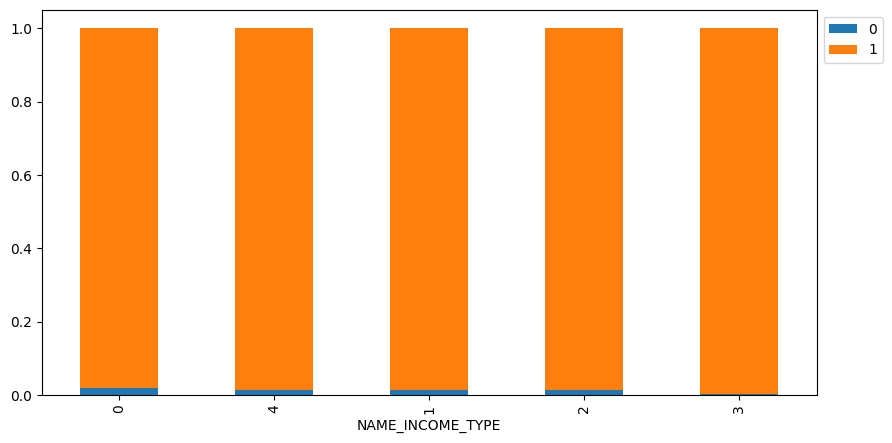

In [86]:
stacked_barplot(df_credit, "NAME_INCOME_TYPE", "STATUS")

STATUS               0       1     All
FLAG_OWN_REALTY                       
All              11575  766140  777715
1                 7217  505731  512948
0                 4358  260409  264767
------------------------------------------------------------------------------------------------------------------------


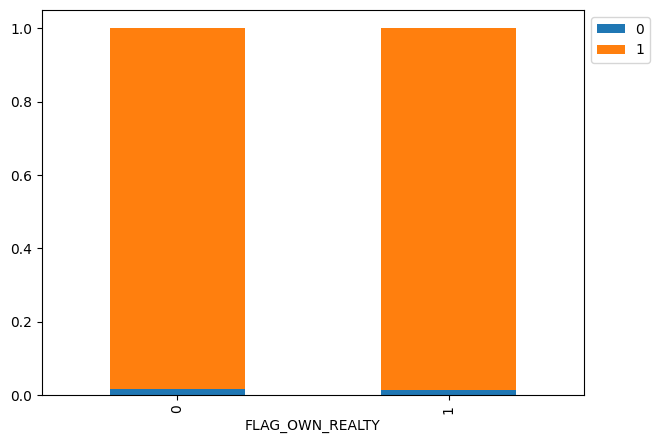

In [87]:
stacked_barplot(df_credit, "FLAG_OWN_REALTY", "STATUS")

STATUS            0       1     All
FLAG_OWN_CAR                       
All           11575  766140  777715
0              7204  466151  473355
1              4371  299989  304360
------------------------------------------------------------------------------------------------------------------------


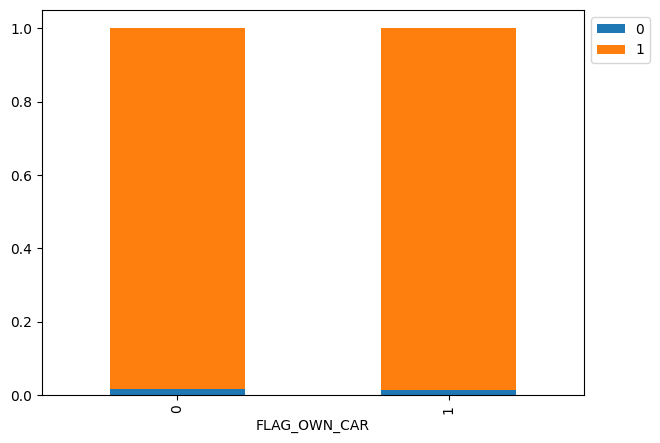

In [88]:
stacked_barplot(df_credit, "FLAG_OWN_CAR", "STATUS")

## Train models

Split data to train and test

In [89]:
from sklearn.model_selection import train_test_split

target = df_credit['STATUS']
features = df_credit.drop(['STATUS'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, train_size=0.75)

In [90]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """

    # checking which probabilities are greater than threshold
    pred_temp = model.predict(predictors) > threshold
    # rounding off the above values to get classes
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf


In [91]:
# defining a function to plot the confusion_matrix of a classification model


def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    threshold: threshold for classifying the observation as class 1
    """
    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Logistic Regression

In [93]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('lr', LogisticRegression(random_state=1))
])

In [94]:
%%time

grid_param = {
    'lr__solver': ['liblinear','newton-cg'],
    'lr__C': np.logspace(-4, 4, 20),
    'lr__penalty': ["l1", "l2"]
    
}

grid_search = GridSearchCV(pipeline, param_grid=grid_param, n_jobs=-1, cv=4, return_train_score=True, scoring='roc_auc')
grid_search.fit(X_train, y_train.values.ravel())

C:\Users\pprab\Anaconda3\envs\credit_card_modeling\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\pprab\Anaconda3\envs\credit_card_modeling\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\pprab\Anaconda3\envs\credit_card_modeling\lib\site-packages\sklearn\pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\pprab\Anaconda3\envs\credit_card_modeling\lib\site-packages\skl

CPU times: total: 3min 13s
Wall time: 2h 58min 27s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('lr',
                                        LogisticRegression(random_state=1))]),
             n_jobs=-1,
             param_grid={'lr__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear', 'newton-cg']},
             return_train_score=True, scoring='roc_auc')

In [95]:
grid_search.best_score_

0.5695886641143243

Metrics

In [113]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix

y_pred_test_ = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_test)

0.5

In [106]:
y_pred_test = grid_search.best_estimator_.predict(X_test)


Testing set performance:
Accuracy: 0.9851668218218476
Precision: 0.9851668218218476
Recall: 1.0
F1: 0.9925279941135932


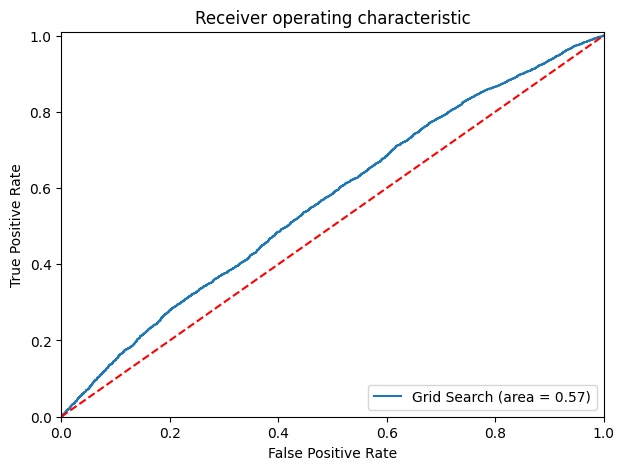

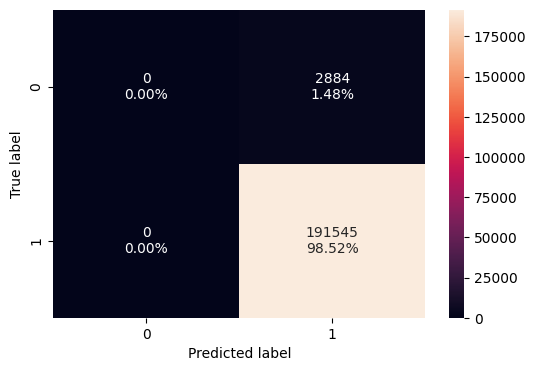

In [114]:
print("Testing set performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1:", f1_score(y_test, y_pred_test))

logit_roc_auc_train = roc_auc_score(y_test, y_pred_test_)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Grid Search (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# creating confusion matrix
confusion_matrix_statsmodels(grid_search.best_estimator_, X_test, y_test)

# KNN

In [115]:
pipelineKNN = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("knn", KNeighborsClassifier())
])

In [116]:
grid_knn_param = {
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': range(2, 8)
}

grid_search_KNN = GridSearchCV(pipelineKNN, param_grid=grid_knn_param, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search_KNN.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': range(2, 8),
                         'knn__weights': ['uniform', 'distance']},
             scoring='roc_auc')

Metrics

In [119]:
y_pred_test_ = grid_search_KNN.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_test = grid_search_KNN.best_estimator_.predict(X_test)

roc_auc_score(y_test, y_pred_test_)

0.8407735790965276

Testing set performance:
Accuracy: 0.9872961338071995
Precision: 0.989200461580655
Recall: 0.9980004698634786
F1: 0.9935809809924272


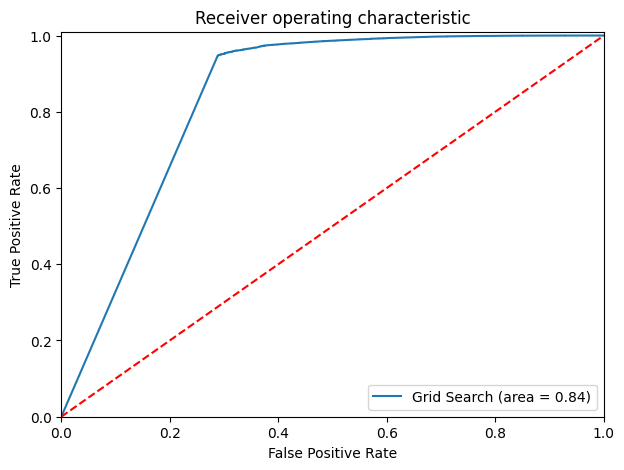

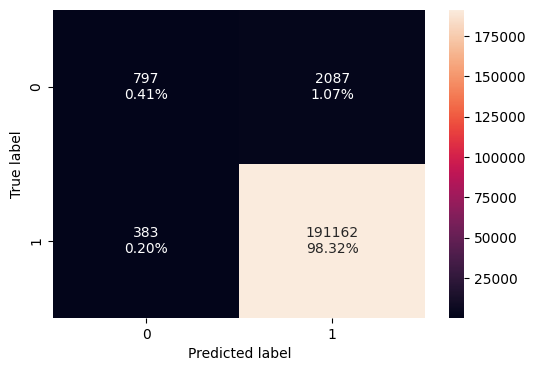

In [124]:
print("Testing set performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1:", f1_score(y_test, y_pred_test))

logit_roc_auc_train = roc_auc_score(y_test, y_pred_test_)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Grid Search (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# creating confusion matrix
confusion_matrix_statsmodels( grid_search_KNN.best_estimator_, X_test, y_test)

# Random Forest

Tuning and training

In [125]:
pipelineForest = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('forest', RandomForestClassifier())
])

In [126]:
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(X_train)
X_train = imputer.transform(X_train)

In [127]:
imputer.fit(X_test)
X_test = imputer.transform(X_test)

In [128]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest.score(X_train, y_train)

0.9999948567255171

Metrics

In [129]:
y_pred_test_ = forest.predict_proba(X_test)[:, 1]
y_pred_test = forest.predict(X_test)

roc_auc_score(y_test, y_pred_test_)

0.8524122754060356

Testing set performance:
Accuracy: 0.986051463516245
Precision: 0.989877292655719
Recall: 0.9960270432535435
F1: 0.9929426459873009


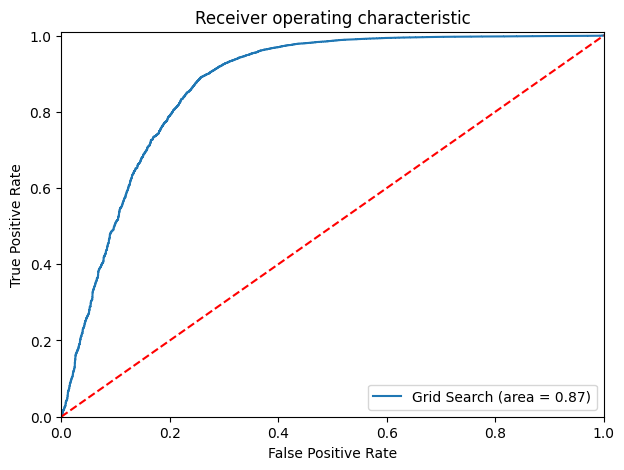

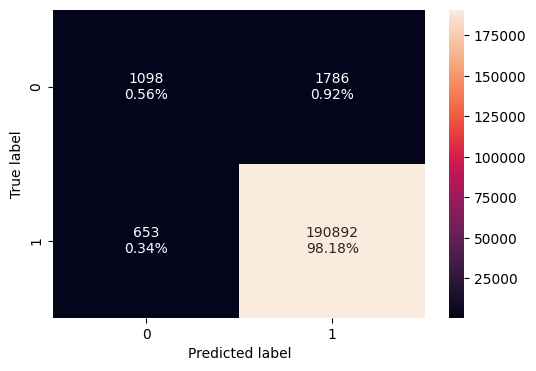

In [139]:
print("Testing set performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1:", f1_score(y_test, y_pred_test))

logit_roc_auc_train = roc_auc_score(y_test, y_pred_test_)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Grid Search (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# creating confusion matrix
confusion_matrix_statsmodels( forest , X_test, y_test)

# Decision Tree

Tuning

In [131]:
pipelineTree = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('tree', DecisionTreeClassifier())
])

In [132]:
grid_tree_params = {
    'tree__max_depth': [7, 9, 11, 13],
    'tree__min_samples_leaf': [8, 10, 12, 15]
}

In [133]:
grid_search_tree = GridSearchCV(pipelineTree, param_grid=grid_tree_params, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search_tree.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('tree', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [7, 9, 11, 13],
                         'tree__min_samples_leaf': [8, 10, 12, 15]},
             scoring='roc_auc')

Metrics

In [ ]:
y_pred_test_ = grid_search_tree.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_test = grid_search_tree.best_estimator_.predict(X_test)

roc_auc_score(y_test, y_pred_test_)

Testing set performance:
Accuracy: 0.9874555750428177
Precision: 0.9907306490621659
Recall: 0.9965908794278107
F1: 0.9936521238967995


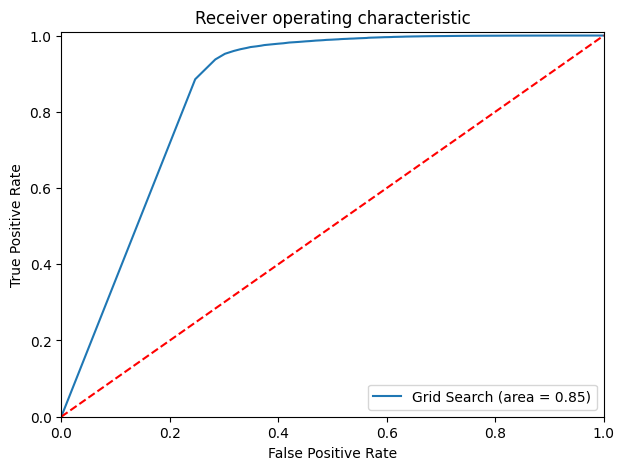

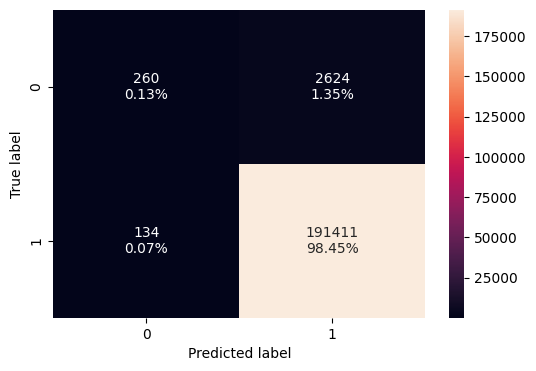

In [134]:
print("Testing set performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1:", f1_score(y_test, y_pred_test))

logit_roc_auc_train = roc_auc_score(y_test, y_pred_test_)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Grid Search (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# creating confusion matrix
confusion_matrix_statsmodels( grid_search_tree.best_estimator_, X_test, y_test)

# Gradient Boosting

In [135]:
boost = GradientBoostingClassifier(n_estimators=200, max_depth=10)
boost.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=200)

Mertics

In [136]:
y_pred_test_ = boost.predict_proba(X_test)[:, 1]
y_pred_test = boost.predict(X_test)

roc_auc_score(y_test, y_pred_test)

0.6597680292550658

Testing set performance:
Accuracy: 0.986051463516245
Precision: 0.989877292655719
Recall: 0.9960270432535435
F1: 0.9929426459873009


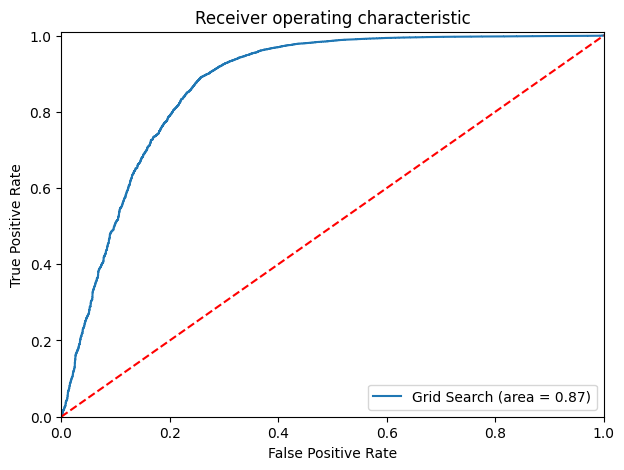

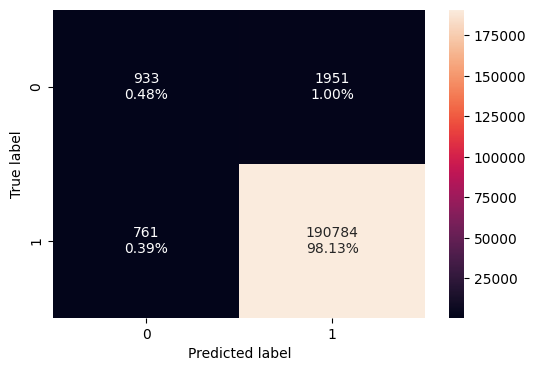

In [137]:
print("Testing set performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1:", f1_score(y_test, y_pred_test))

logit_roc_auc_train = roc_auc_score(y_test, y_pred_test_)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Grid Search (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# creating confusion matrix
confusion_matrix_statsmodels(boost, X_test, y_test)

##### Best model is gradient boosting with roc-auc score: 0.87. Random forest and adaBoost show high score (0.85, 0.84). Among non-ensemble methods